# Fallback - Product Propensity Scoring
* StellarAlgo Data Science
* Ryan Kazmerik
* Oct 19, 2022

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [15]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022

## Model Training

In [16]:
df = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(699157, 27)

In [17]:
# choose the features for the stellar base PP model
features = [
    "atp_last",
    "attendedpct_last",
    "attendedpct_prior",
    "attendance_current",
    "attended_last",
    "attended_prior",
    "clientcode",
    "dimcustomermasterid",
    "date_last_save",
    "date_last_send",
    "date_last_touch",
    "events_last",
    "events_prior",
    "distance",
    "events_current",
    "lkupclientid",
    "opens",
    "opens_prior",
    "product",
    "product_current",
    "product_last",
    "seasonyear",
    "sends",
    "sends_prior",
    "spend_current",
    "tenure",
    "volume_current"
]

# copy your main dataframe
df_dataset = df

# creating the training and evaluation dataframe
df_dataset = df_dataset[features]

# limiting classes to only product plans
product_plans = ["Full Season", "Half Season", "Quarter", "Mini Pack"]

df_dataset = df_dataset[df_dataset["product"].isin(product_plans)]

df_train = df_dataset.sample(frac=0.90, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14342, 27)
Unseen Data For Predictions: (1594, 27)



In [18]:
setup(
    data= df_train, 
    target="product", 
    train_size = 0.90,
    data_split_shuffle=True,
    ignore_features=[
        "attended_last",
        "attendedpct_last",
        "clientcode",
        "date_last_save",
        "date_last_send",
        "date_last_touch",
        "dimcustomermasterid",
        "distance",
        "events_current",
        "lkupclientid",
        "opens",
        "opens_prior",
        #"product_current",
        #"product_last",
        "seasonyear",
        "sends",
        "sends_prior",
        #"spend_current",
        "volume_current"
    ],
    silent=True,
    verbose=False,
    categorical_features=[
        "product_current",
        "product_last",
    ],
    numeric_features=[
        "atp_last",
        "attendance_current",
        "attendedpct_prior",
        "attended_prior",
        "events_last",
        "events_prior",
        "spend_current",
        "tenure"
    ]
);

In [19]:
model_matrix = compare_models(
    fold=10,
    include=["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8725,0.9514,0.6773,0.8684,0.8696,0.7571,0.7576,1.0740


In [20]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8784,0.9511,0.6589,0.8702,0.8734,0.7666,0.7671
1,0.8575,0.9426,0.6193,0.8503,0.8520,0.7259,0.7270
2,0.8722,0.9538,0.6786,0.8691,0.8690,0.7572,0.7580
3,0.8784,0.9555,0.6990,0.8766,0.8760,0.7699,0.7706
4,0.8807,0.9524,0.6845,0.8752,0.8772,0.7732,0.7734
5,0.8753,0.9569,0.6905,0.8731,0.8740,0.7640,0.7640
6,0.8776,0.9515,0.6843,0.8732,0.8745,0.7675,0.7678
7,0.8581,0.9404,0.6718,0.8551,0.8562,0.7296,0.7299
8,0.8837,0.9590,0.6900,0.8772,0.8798,0.7748,0.7756


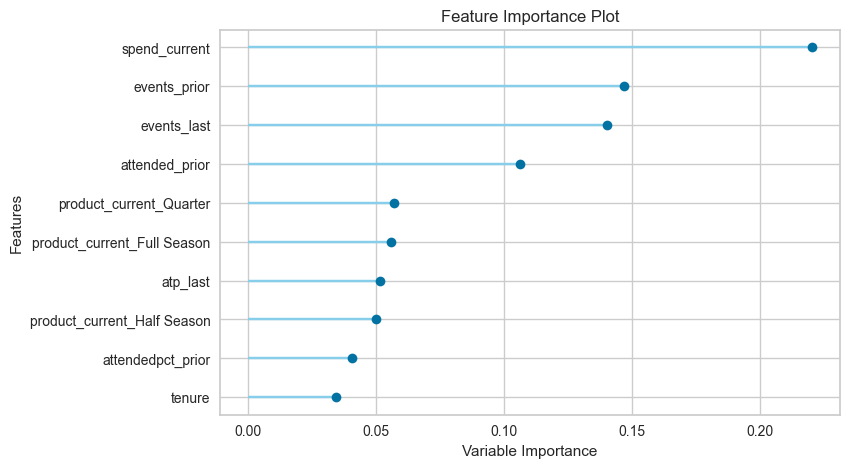

In [21]:
plot_model(final_model, plot='feature')

## Model Inference

### Let's load in our inference data and get retention scores using the model:

In [22]:
df_inference = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=1
)

# remove the target column from the inference df
df_inference = df_inference.drop(columns=["product"], axis=1)

df_inference.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(387707, 26)

In [23]:
df_scores = predict_model(final_model, data=df_inference)

## Upsell Leads

In [24]:
df_upsell = df_scores[df_scores["product_current"].isin(product_plans)]

df_upsell_aggs = df_upsell.groupby(["Label","product_current"]).agg({
    "Label": "count",
})
df_upsell_aggs.columns = ["count"]

df_upsell_aggs

count
Label       product_current       
Full Season Full Season        276
            Half Season         21
            Mini Pack            5
            Quarter              1
Half Season Half Season        235
            Mini Pack            2
            Quarter              3
Mini Pack   Mini Pack           16
Quarter     Full Season          6
            Half Season          5
            Mini Pack           19
            Quarter            583

## Individual + None Leads

In [25]:
df_other = df_scores[df_scores["product_current"].isin(["Individual", "None"])]

### Let's examine the top 20 Full Season leads in this grouping:

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_other[df_other["Label"]=="Full Season"].sort_values(by="Score", ascending=False).head(20)

,lkupclientid,clientcode,dimcustomermasterid,seasonyear,distance,tenure,events_prior,attended_prior,attendedpct_prior,events_last,attended_last,attendedpct_last,atp_last,product_last,product_current,spend_current,volume_current,attendance_current,events_current,sends,sends_prior,opens,opens_prior,date_last_send,date_last_touch,date_last_save,Label,Score
41664,7,CANUCKS,117581,2022,9.66,5,162,157,0.96913580246913580,38,37,0.97368421052631578,69.43,Full Season,None,7323.6,108,0.97222222222222222,36,33.0,14.0,70.0,45.0,2022-10-13,None,2022-10-19,Full Season,0.98
82846,7,CANUCKS,235884,2022,23.43,7,252,187,0.74206349206349206,38,33,0.86842105263157894,62.32,Individual,None,4033.8,72,0.58333333333333333,36,43.0,22.0,70.0,65.0,2022-10-14,None,2022-10-19,Full Season,0.98
93296,7,CANUCKS,262047,2022,3.97,5,162,154,0.95061728395061728,38,36,0.94736842105263157,69.73,None,None,9764.8,144,0.88888888888888888,36,33.0,13.0,68.0,46.0,2022-10-13,None,2022-10-14,Full Season,0.98
21480,7,CANUCKS,58639,2022,12.16,5,162,157,0.96913580246913580,38,38,1.00000000000000000,69.43,None,None,7323.6,108,0.88888888888888888,36,33.0,13.0,70.0,44.0,2022-10-13,None,2022-10-14,Full Season,0.98
249794,7,CANUCKS,644106,2022,9.13,5,162,86,0.53086419753086419,38,0,0E-17,70.65,None,None,9764.8,144,0E-17,36,23.0,14.0,10.0,35.0,2022-10-13,None,2022-10-14,Full Season,0.98
59052,7,CANUCKS,125288,2022,23.84,7,252,190,0.75396825396825396,38,25,0.65789473684210526,56.19,Individual,None,4192.3,74,0.47222222222222222,36,44.0,22.0,150.0,120.0,2022-10-13,None,2022-10-18,Full Season,0.98
360926,7,CANUCKS,454100438,2022,27.29,7,45,41,0.91111111111111111,0,0,0E-17,0.00,None,None,0.0,0,0E-17,0,NaN,NaN,NaN,NaN,None,None,2022-09-29,Full Season,0.97
223731,7,CANUCKS,548448,2022,3.18,7,45,41,0.91111111111111111,0,0,0E-17,0.00,None,None,0.0,0,0E-17,0,2.0,0.0,4.0,0.0,2022-09-23,None,2022-09-22,Full Season,0.97
28982,7,CANUCKS,93389,2022,61.52,7,45,41,0.91111111111111111,0,0,0E-17,0.00,None,None,0.0,0,0E-17,0,18.0,15.0,12.0,8.0,2022-10-12,None,2022-10-12,Full Season,0.97
142480,7,CANUCKS,349418,2022,1.65,7,45,41,0.91111111111111111,0,0,0E-17,0.00,None,None,0.0,0,0E-17,0,1.0,0.0,0.0,0.0,2022-09-23,None,2022-09-22,Full Season,0.97
